In [2]:
using PyPlot, StatsBase, Printf, DelimitedFiles, Combinatorics;
using Revise;
using MDToolbox;
PyPlot.plt.style.use("seaborn-colorblind");
ENV["COLUMNS"] = 110; #display width for MDToolbox

┌ Warning: no Manifest.toml file found, static paths used
└ @ Revise /Users/nakayama/.julia/packages/Revise/AMRie/src/Revise.jl:1167
┌ Info: CUDAdrv.jl failed to initialize, GPU functionality unavailable (set JULIA_CUDA_SILENT or JULIA_CUDA_VERBOSE to silence or expand this message)
└ @ CUDAdrv /Users/nakayama/.julia/packages/CUDAdrv/aBgcd/src/CUDAdrv.jl:69


### Potential energy function its gradients

In [3]:
V(x; k=1.0) = sum(- (1.0 / 2.0) .* k .* x.^2 .+ (1.0 ./ 4.0) .* k .* x.^4)
V([0.0])

0.0

In [4]:
proposal_fun(x) = x .+ (rand(Float64, size(x)) .* 2.0 .- 1.0);
proposal_fun([0.0])

1-element Array{Float64,1}:
 -0.1623210994286417

### Define functions for infinite swapping

温度Tにおけるxの分布は、以下のπに比例する

\begin{align}
\pi({\bf x},T) = e^{-V({\bf x})/T}
\end{align}

In [5]:
pai(x, T) = exp.(-V(x) ./ T)

pai (generic function with 1 method)

ρ_n(X)はある温度における期待値を求める際の「重み」のようなもの

\begin{align}
\rho_n({\bf X}) = \frac{P_n \left[ \pi({\bf x}_1, T_1) \pi({\bf x}_2, T_2) \ldots \pi({\bf x}_N, T_N) \right]}{\mu({\bf X})}
\end{align}

ここでμ(X)はsymmetrized distribution

\begin{align}
\mu({\bf X})  = \sum_{n=1}^{N!} P_n \left[ \pi({\bf x}_1, T_1) \pi({\bf x}_2, T_2) \ldots \pi({\bf x}_N, T_N) \right]
\end{align}


物理量A(x)の温度T_kにおける期待値は以下のように求められる

\begin{align}
< A >_k = \frac{\int \mu({\bf X}) \left[ \sum_{n=1}^{N!}\rho_n({\bf X}) A({\bf x}_{indx(n,k)}) \right] d{\bf X}}{\int \mu({\bf X}) d{\bf X}}
\end{align}

これを時間平均でもとめると
\begin{align}
< A >_k = \frac{1}{M} \sum_{m=0}^{M} \sum_{n=1}^{N!}\rho_n({\bf X}_m) A({\bf x}_{indx(n,k),m})
\end{align}

In [6]:
function calc_rho!(rho, x, T, perm)
    nreplica = length(x)
    nperm = length(rho)
    mu = 0.0
    for n = 1:nperm
        for i = 1:nreplica
            rho[n] *= pai(x[i], T[perm[n][i]])
        end
        mu += rho[n]
    end
    rho .= rho./mu
    return rho
end

calc_rho! (generic function with 1 method)

In [7]:
function select_n(rho)
    rho_cumsum = cumsum(rho)
    r = rand()
    n = sum(r .> rho_cumsum ) + 1
    return n
end

select_n (generic function with 1 method)

### Infinite swap MCMC

In [8]:
function flush_weight(io::IOStream, m, rho, perm)
    nperm = length(rho)
    nreplica = length(perm[1])
    weight = zeros(Float64, nreplica)
    
    for n = 1:nperm
        #id_replica = perm[n][m]
        id_replica = findall(iszero, perm[n] .- m)[1]
        weight[id_replica] += rho[n]
    end
    
    for i = 1:nreplica
        @printf(io, "%f ", weight[i])
    end
    @printf(io, "\n")
end

flush_weight (generic function with 1 method)

In [9]:
nreplica = 4
temperature_replica = [0.01, 0.10, 0.30, 0.40];
nstep = 2000;
perm=collect(permutations(1:nreplica))
nperm=factorial(nreplica)

x_replica = []
for i = 1:nreplica
    x = [0.0]
    push!(x_replica, x)
end

io_replica = []
for i = 1:nreplica
    filename = "replica$(i).dat"
    io = open(filename, "w")
    push!(io_replica, io)
end

io_weight=[]
for m = 1:nreplica
    filename = "weight$(m).dat"
    io = open(filename, "w")
    push!(io_weight, io)
end

In [10]:
rho=ones(Float64, nperm)
calc_rho!(rho, x_replica, temperature_replica, perm)
   
icount = 0
for istep = 1:nstep
    n = select_n(rho)  
    for i = 1:nreplica
        x_replica[i] = propagate_mcmc(V, proposal_fun, x_replica[i], temperature_replica[perm[n][i]], nstep=1, io=io_replica[i]);       
    end
    calc_rho!(rho, x_replica, temperature_replica, perm)

    for m = 1:nreplica
        flush_weight(io_weight[m], m, rho, perm)
    end
end

In [11]:
for i = 1:nreplica
    close(io_replica[i])
    close(io_weight[i])
end

### Trajectory analysis

In [12]:
traj_replica = []
temp_replica = []

for i = 1:nreplica
    filename = "replica$(i).dat"
    data = readdlm(filename);
    push!(temp_replica, data[:, 1])
    push!(traj_replica, data[:, 2])
end

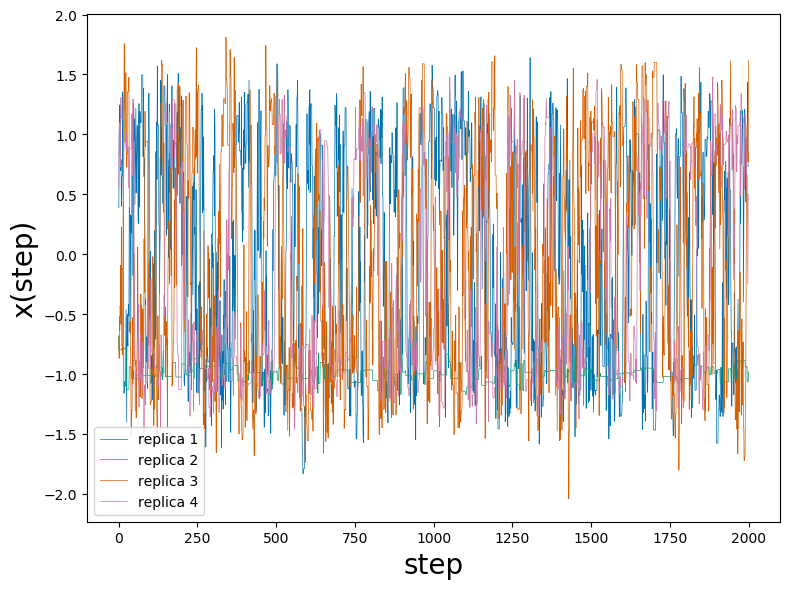

In [13]:
fig, ax = subplots(figsize=(8, 6))
for i = 1:nreplica
    ax.plot(traj_replica[i], linewidth=0.5)   
end
xlabel("step",fontsize=20)
ylabel("x(step)",fontsize=20)

ax.legend(["replica 1", "replica 2", "replica 3", "replica 4"])
tight_layout()

In [14]:
filename = "weight2.dat"
weight_replica = readdlm(filename);

In [15]:
traj = traj_replica[1]
weight = weight_replica[:, 1]

for i = 2:nreplica
    traj = [traj; traj_replica[i]]
    weight = [weight; weight_replica[:, i]]
end
weight .= weight ./ sum(weight)

8000-element Array{Float64,1}:
 0.0001063290000531645 
 6.180300003090149e-5  
 6.639350003319675e-5  
 0.0001055590000527795 
 9.176350004588175e-5  
 0.00012159950006079975
 0.00011591800005795899
 0.00016420350008210173
 0.00023930050011965024
 0.000121036000060518  
 5.548850002774425e-5  
 3.7409000018704494e-5 
 2.4811500012405747e-5 
 ⋮                     
 0.00050000000025      
 0.00050000000025      
 0.00050000000025      
 0.00050000000025      
 0.00050000000025      
 0.00050000000025      
 0.00050000000025      
 0.00050000000025      
 0.00050000000025      
 0.00050000000025      
 0.00050000000025      
 0.00050000000025      

In [16]:
x_grid = range(-1.3, 1.3, length=100);
pmf_theory = V.(x_grid) ./ temperature_replica[2]
pmf_theory .= pmf_theory .- minimum(pmf_theory);

In [17]:
#pmf_observed, _ = getpmf(traj_replica[1], weight=weight_replica[:, 1], grid_x = collect(x_grid), bandwidth=0.05);
pmf_observed, _ = getpmf(traj, weight=weight, grid_x = collect(x_grid), bandwidth=0.05);

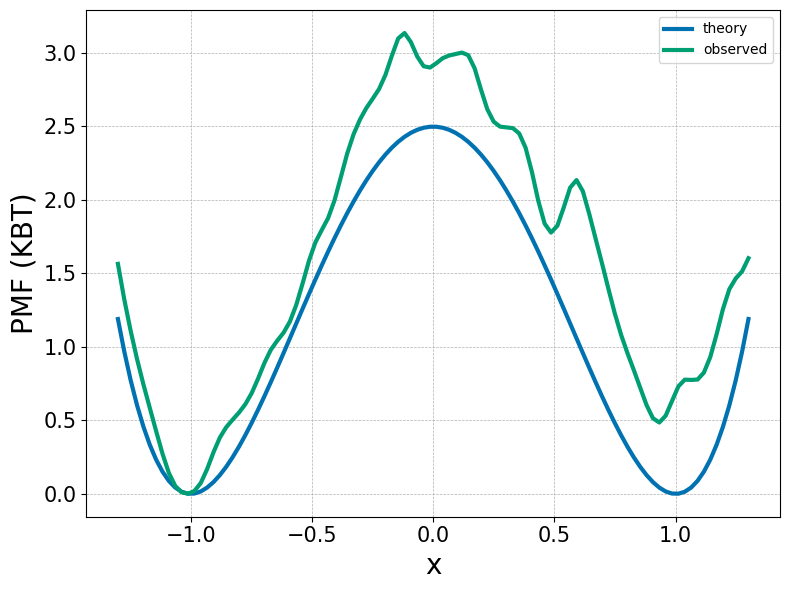

In [18]:
fig, ax = subplots(figsize=(8, 6))
ax.plot(x_grid, pmf_theory, linewidth=3)
xlabel("x",fontsize=20)
ylabel("PMF (KBT)",fontsize=20)

ax.plot(x_grid, pmf_observed, linewidth=3)

ax.legend(["theory", "observed"])

ax.xaxis.set_tick_params(which="major",labelsize=15)
ax.yaxis.set_tick_params(which="major",labelsize=15)
ax.grid(linestyle="--", linewidth=0.5)
tight_layout()
savefig("mcmc_infinite_swap.png", dpi=350)

In [20]:
fig, ax = subplots(figsize=(8, 6))
ax.plot(x_grid, pmf_theory, linewidth=3)
xlabel("x",fontsize=20)
ylabel("PMF (KBT)",fontsize=20)
ax.errorbar(x, y, interv  val, fmt='ro', capsize=4, ecolor='black')

ax.plot(x_grid, pmf_observed, linewidth=3)

ax.legend(["theory", "observed"])

ax.xaxis.set_tick_params(which="major",labelsize=15)
ax.yaxis.set_tick_params(which="major",labelsize=15)
ax.grid(linestyle="--", linewidth=0.5)
tight_layout()
#savefig("mcmc_infinite_swap.png", dpi=350)



LoadError: syntax: invalid character literal